In [4]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [17]:
import os
import shutil
import pandas as pd
from pathlib import Path

# ========== CONFIG ==========
dataset_root = "/content/drive/MyDrive/Final Spectrogram/Gray/GraySpectrogram_Data"
output_root = "/content/drive/MyDrive/Final Spectrogram/Gray/Lebel_Data"
output_image_dir = os.path.join(output_root, "all_images")
output_csv_path = os.path.join(output_root, "labels.csv")
os.makedirs(output_image_dir, exist_ok=True)

valves = ["mitral", "aortic", "tricuspid", "pulmonary"]
splits = ["train", "val", "test"]

records = []

# ========== LOOP ทุก Valve ==========
for valve in valves:
    dataset_path = os.path.join(dataset_root, f"dataset_{valve}")
    for split in splits:
        for label_folder in ["Normal", "Abnormal"]:
            label = 0 if label_folder == "Normal" else 1
            image_dir = os.path.join(dataset_path, split, label_folder)
            if not os.path.exists(image_dir): continue

            for fname in os.listdir(image_dir):
                if not fname.endswith(".png"): continue

                src = os.path.join(image_dir, fname)
                new_fname = f"{valve}_{split}_{label}_{fname}"
                dst = os.path.join(output_image_dir, new_fname)
                shutil.copy(src, dst)

                records.append({
                    "filename": new_fname,
                    "valve": valve,
                    "label": label,
                    "split": split
                })

# ========== SAVE CSV ==========
df = pd.DataFrame(records)
df.to_csv(output_csv_path, index=False)
print(f"✅ Saved labels.csv with {len(df)} records")


✅ Saved labels.csv with 1229 records


In [1]:
from torch.utils.data import Dataset
from PIL import Image
import torch

valve_to_idx = {"mitral": 0, "aortic": 1, "tricuspid": 2, "pulmonary": 3}

class HeartValveDataset(Dataset):
    def __init__(self, csv_file, image_dir, split, transform=None):
        import pandas as pd
        self.df = pd.read_csv(csv_file)
        self.df = self.df[self.df["split"] == split].reset_index(drop=True)
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        image_path = os.path.join(self.image_dir, row["filename"])
        image = Image.open(image_path).convert("L")  # grayscale

        if self.transform:
            image = self.transform(image)

        valve_idx = valve_to_idx[row["valve"]]
        label = torch.tensor([row["label"]], dtype=torch.float32)
        return image, valve_idx, label


In [2]:
import torch.nn as nn
import torch

class MultiValveCNN(nn.Module):
    def __init__(self, num_valves=4):
        super().__init__()
        self.embedding = nn.Embedding(num_valves, 16)  # valve → vector
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 16, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(16, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
        )
        self.fc = nn.Sequential(
            nn.Flatten(),  # image → feature
            nn.Linear(32 * 56 * 56 + 16, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 1)  # binary output
        )

    def forward(self, x, valve_idx):
        x_feat = self.cnn(x)                         # [B, 32, 56, 56]
        v_feat = self.embedding(valve_idx)           # [B, 16]
        x_feat = torch.flatten(x_feat, 1)            # [B, flat]
        all_feat = torch.cat((x_feat, v_feat), dim=1)
        out = self.fc(all_feat)
        return out


In [5]:
from torchvision import transforms
from torch.utils.data import DataLoader

# ========== CONFIG ==========
BATCH_SIZE = 32
IMAGE_SIZE = (224, 224)
CSV_PATH = "/content/drive/MyDrive/Final Spectrogram/Gray/Lebel_Data/labels.csv"
IMAGE_DIR = "/content/drive/MyDrive/Final Spectrogram/Gray/Lebel_Data/all_images"

# ========== TRANSFORM ==========
transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])  # grayscale
])

# ========== LOAD DATA ==========
train_set = HeartValveDataset(CSV_PATH, IMAGE_DIR, split="train", transform=transform)
val_set   = HeartValveDataset(CSV_PATH, IMAGE_DIR, split="val", transform=transform)
test_set  = HeartValveDataset(CSV_PATH, IMAGE_DIR, split="test", transform=transform)

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False)
test_loader  = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False)


In [15]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

# ========== SETUP ==========
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MultiValveCNN().to(device)

# ========== LOSS FUNCTION WITHOUT POS_WEIGHT ==========
criterion = nn.BCEWithLogitsLoss()  # ไม่มี pos_weight
optimizer = optim.Adam(model.parameters(), lr=0.001)
EPOCHS = 20

# ========== TRACK METRICS ==========
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

# ========== TRAINING ==========
for epoch in range(EPOCHS):
    model.train()
    total_loss, correct, total = 0.0, 0, 0

    # Training loop
    for images, valve_idx, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}"):
        images, valve_idx, labels = images.to(device), valve_idx.to(device), labels.to(device)

        outputs = model(images, valve_idx)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * images.size(0)

        preds = torch.sigmoid(outputs) > 0.5
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_acc = correct / total
    avg_loss = total_loss / total

    # ✅ เก็บค่าต่อ epoch (Training)
    train_losses.append(avg_loss)
    train_accuracies.append(train_acc)

    print(f"✅ Epoch {epoch+1}: Train Loss = {avg_loss:.4f} | Train Acc = {train_acc:.4f}")

    # ========== VALIDATION ==========
    model.eval()  # Set the model to evaluation mode
    val_loss, val_correct, val_total = 0.0, 0, 0

    with torch.no_grad():  # Disable gradient computation for validation
        for images, valve_idx, labels in tqdm(val_loader, desc=f"Validation Epoch {epoch+1}/{EPOCHS}"):
            images, valve_idx, labels = images.to(device), valve_idx.to(device), labels.to(device)

            outputs = model(images, valve_idx)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * images.size(0)

            preds = torch.sigmoid(outputs) > 0.5
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    val_acc = val_correct / val_total
    avg_val_loss = val_loss / val_total

    # ✅ เก็บค่าต่อ epoch (Validation)
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_acc)

    print(f"✅ Epoch {epoch+1}: Val Loss = {avg_val_loss:.4f} | Val Acc = {val_acc:.4f}")

    # ========== SAVE MODEL ==========
    model_save_path = f"/content/drive/MyDrive/Final Spectrogram/Final Model/model_epoch_{epoch+1}.pt"
    torch.save(model.state_dict(), model_save_path)
    print(f"💾 Saved model at epoch {epoch+1} to {model_save_path}")


Epoch 1/20: 100%|██████████| 28/28 [00:04<00:00,  5.72it/s]


✅ Epoch 1: Train Loss = 0.9882 | Train Acc = 0.6055


Validation Epoch 1/20: 100%|██████████| 6/6 [00:01<00:00,  5.64it/s]


✅ Epoch 1: Val Loss = 0.5577 | Val Acc = 0.6740
💾 Saved model at epoch 1 to /content/drive/MyDrive/Final Spectrogram/Final Model/model_epoch_1.pt


Epoch 2/20: 100%|██████████| 28/28 [00:04<00:00,  5.72it/s]


✅ Epoch 2: Train Loss = 0.5440 | Train Acc = 0.6920


Validation Epoch 2/20: 100%|██████████| 6/6 [00:00<00:00,  7.18it/s]


✅ Epoch 2: Val Loss = 0.5201 | Val Acc = 0.6740
💾 Saved model at epoch 2 to /content/drive/MyDrive/Final Spectrogram/Final Model/model_epoch_2.pt


Epoch 3/20: 100%|██████████| 28/28 [00:06<00:00,  4.40it/s]


✅ Epoch 3: Train Loss = 0.5137 | Train Acc = 0.7209


Validation Epoch 3/20: 100%|██████████| 6/6 [00:02<00:00,  2.40it/s]


✅ Epoch 3: Val Loss = 0.4739 | Val Acc = 0.7845
💾 Saved model at epoch 3 to /content/drive/MyDrive/Final Spectrogram/Final Model/model_epoch_3.pt


Epoch 4/20: 100%|██████████| 28/28 [00:04<00:00,  5.85it/s]


✅ Epoch 4: Train Loss = 0.4641 | Train Acc = 0.7509


Validation Epoch 4/20: 100%|██████████| 6/6 [00:00<00:00,  7.15it/s]


✅ Epoch 4: Val Loss = 0.4446 | Val Acc = 0.7735
💾 Saved model at epoch 4 to /content/drive/MyDrive/Final Spectrogram/Final Model/model_epoch_4.pt


Epoch 5/20: 100%|██████████| 28/28 [00:06<00:00,  4.20it/s]


✅ Epoch 5: Train Loss = 0.4096 | Train Acc = 0.8051


Validation Epoch 5/20: 100%|██████████| 6/6 [00:00<00:00,  6.56it/s]


✅ Epoch 5: Val Loss = 0.4173 | Val Acc = 0.7459
💾 Saved model at epoch 5 to /content/drive/MyDrive/Final Spectrogram/Final Model/model_epoch_5.pt


Epoch 6/20: 100%|██████████| 28/28 [00:06<00:00,  4.20it/s]


✅ Epoch 6: Train Loss = 0.3792 | Train Acc = 0.8097


Validation Epoch 6/20: 100%|██████████| 6/6 [00:00<00:00,  6.63it/s]


✅ Epoch 6: Val Loss = 0.4859 | Val Acc = 0.7348
💾 Saved model at epoch 6 to /content/drive/MyDrive/Final Spectrogram/Final Model/model_epoch_6.pt


Epoch 7/20: 100%|██████████| 28/28 [00:05<00:00,  5.20it/s]


✅ Epoch 7: Train Loss = 0.3576 | Train Acc = 0.8235


Validation Epoch 7/20: 100%|██████████| 6/6 [00:01<00:00,  3.41it/s]


✅ Epoch 7: Val Loss = 0.3869 | Val Acc = 0.7901
💾 Saved model at epoch 7 to /content/drive/MyDrive/Final Spectrogram/Final Model/model_epoch_7.pt


Epoch 8/20: 100%|██████████| 28/28 [00:04<00:00,  5.74it/s]


✅ Epoch 8: Train Loss = 0.3252 | Train Acc = 0.8466


Validation Epoch 8/20: 100%|██████████| 6/6 [00:00<00:00,  6.86it/s]


✅ Epoch 8: Val Loss = 0.3363 | Val Acc = 0.8287
💾 Saved model at epoch 8 to /content/drive/MyDrive/Final Spectrogram/Final Model/model_epoch_8.pt


Epoch 9/20: 100%|██████████| 28/28 [00:07<00:00,  3.61it/s]


✅ Epoch 9: Train Loss = 0.2830 | Train Acc = 0.8662


Validation Epoch 9/20: 100%|██████████| 6/6 [00:00<00:00,  6.71it/s]


✅ Epoch 9: Val Loss = 0.3534 | Val Acc = 0.8287
💾 Saved model at epoch 9 to /content/drive/MyDrive/Final Spectrogram/Final Model/model_epoch_9.pt


Epoch 10/20: 100%|██████████| 28/28 [00:04<00:00,  5.68it/s]


✅ Epoch 10: Train Loss = 0.2804 | Train Acc = 0.8685


Validation Epoch 10/20: 100%|██████████| 6/6 [00:00<00:00,  6.16it/s]


✅ Epoch 10: Val Loss = 0.3261 | Val Acc = 0.8398
💾 Saved model at epoch 10 to /content/drive/MyDrive/Final Spectrogram/Final Model/model_epoch_10.pt


Epoch 11/20: 100%|██████████| 28/28 [00:05<00:00,  5.32it/s]


✅ Epoch 11: Train Loss = 0.2292 | Train Acc = 0.9066


Validation Epoch 11/20: 100%|██████████| 6/6 [00:00<00:00,  7.25it/s]


✅ Epoch 11: Val Loss = 0.3363 | Val Acc = 0.8343
💾 Saved model at epoch 11 to /content/drive/MyDrive/Final Spectrogram/Final Model/model_epoch_11.pt


Epoch 12/20: 100%|██████████| 28/28 [00:08<00:00,  3.23it/s]


✅ Epoch 12: Train Loss = 0.1952 | Train Acc = 0.9227


Validation Epoch 12/20: 100%|██████████| 6/6 [00:00<00:00,  6.34it/s]


✅ Epoch 12: Val Loss = 0.3814 | Val Acc = 0.8122
💾 Saved model at epoch 12 to /content/drive/MyDrive/Final Spectrogram/Final Model/model_epoch_12.pt


Epoch 13/20: 100%|██████████| 28/28 [00:04<00:00,  5.82it/s]


✅ Epoch 13: Train Loss = 0.1791 | Train Acc = 0.9331


Validation Epoch 13/20: 100%|██████████| 6/6 [00:00<00:00,  7.07it/s]


✅ Epoch 13: Val Loss = 0.3583 | Val Acc = 0.8177
💾 Saved model at epoch 13 to /content/drive/MyDrive/Final Spectrogram/Final Model/model_epoch_13.pt


Epoch 14/20: 100%|██████████| 28/28 [00:06<00:00,  4.17it/s]


✅ Epoch 14: Train Loss = 0.1596 | Train Acc = 0.9366


Validation Epoch 14/20: 100%|██████████| 6/6 [00:00<00:00,  6.41it/s]


✅ Epoch 14: Val Loss = 0.4093 | Val Acc = 0.8177
💾 Saved model at epoch 14 to /content/drive/MyDrive/Final Spectrogram/Final Model/model_epoch_14.pt


Epoch 15/20: 100%|██████████| 28/28 [00:05<00:00,  4.79it/s]


✅ Epoch 15: Train Loss = 0.1145 | Train Acc = 0.9654


Validation Epoch 15/20: 100%|██████████| 6/6 [00:00<00:00,  6.81it/s]


✅ Epoch 15: Val Loss = 0.4731 | Val Acc = 0.8011
💾 Saved model at epoch 15 to /content/drive/MyDrive/Final Spectrogram/Final Model/model_epoch_15.pt


Epoch 16/20: 100%|██████████| 28/28 [00:05<00:00,  5.08it/s]


✅ Epoch 16: Train Loss = 0.1105 | Train Acc = 0.9631


Validation Epoch 16/20: 100%|██████████| 6/6 [00:00<00:00,  6.94it/s]


✅ Epoch 16: Val Loss = 0.5278 | Val Acc = 0.8011
💾 Saved model at epoch 16 to /content/drive/MyDrive/Final Spectrogram/Final Model/model_epoch_16.pt


Epoch 17/20: 100%|██████████| 28/28 [00:05<00:00,  4.72it/s]


✅ Epoch 17: Train Loss = 0.0982 | Train Acc = 0.9689


Validation Epoch 17/20: 100%|██████████| 6/6 [00:01<00:00,  3.44it/s]


✅ Epoch 17: Val Loss = 0.4889 | Val Acc = 0.7901
💾 Saved model at epoch 17 to /content/drive/MyDrive/Final Spectrogram/Final Model/model_epoch_17.pt


Epoch 18/20: 100%|██████████| 28/28 [00:05<00:00,  5.13it/s]


✅ Epoch 18: Train Loss = 0.0808 | Train Acc = 0.9792


Validation Epoch 18/20: 100%|██████████| 6/6 [00:00<00:00,  7.07it/s]


✅ Epoch 18: Val Loss = 0.5902 | Val Acc = 0.8011
💾 Saved model at epoch 18 to /content/drive/MyDrive/Final Spectrogram/Final Model/model_epoch_18.pt


Epoch 19/20: 100%|██████████| 28/28 [00:04<00:00,  5.70it/s]


✅ Epoch 19: Train Loss = 0.0523 | Train Acc = 0.9873


Validation Epoch 19/20: 100%|██████████| 6/6 [00:01<00:00,  3.26it/s]


✅ Epoch 19: Val Loss = 0.6452 | Val Acc = 0.8011
💾 Saved model at epoch 19 to /content/drive/MyDrive/Final Spectrogram/Final Model/model_epoch_19.pt


Epoch 20/20: 100%|██████████| 28/28 [00:06<00:00,  4.19it/s]


✅ Epoch 20: Train Loss = 0.0508 | Train Acc = 0.9896


Validation Epoch 20/20: 100%|██████████| 6/6 [00:01<00:00,  3.36it/s]


✅ Epoch 20: Val Loss = 0.7432 | Val Acc = 0.7624
💾 Saved model at epoch 20 to /content/drive/MyDrive/Final Spectrogram/Final Model/model_epoch_20.pt


In [18]:
MODEL_PATH = "/content/drive/MyDrive/Final Spectrogram/Final Model/Gray_CNN_Data_NotPretrain.pt"
torch.save(model.state_dict(), MODEL_PATH)
print(f"💾 Model saved to: {MODEL_PATH}")


💾 Model saved to: /content/drive/MyDrive/Final Spectrogram/Final Model/Gray_CNN_Data_NotPretrain.pt


In [19]:
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix
import torch

# ===== CONFIG =====
valve_to_idx = {"mitral": 0, "aortic": 1, "tricuspid": 2, "pulmonary": 3}
idx_to_valve = {v: k for k, v in valve_to_idx.items()}

# ===== โหลด CSV อีกครั้งเพื่ออ่าน valve
df_labels = pd.read_csv(CSV_PATH)
df_test = df_labels[df_labels["split"] == "test"].reset_index(drop=True)

# ===== เตรียมเก็บผลลัพธ์
results = {valve: {"y_true": [], "y_pred": []} for valve in valve_to_idx}

model.eval()
with torch.no_grad():
    for images, valve_idx, labels in test_loader:
        images = images.to(device)
        valve_idx = valve_idx.to(device)
        labels = labels.to(device)

        outputs = model(images, valve_idx)
        preds = torch.sigmoid(outputs) > 0.5

        for i in range(len(labels)):
            valve_name = idx_to_valve[valve_idx[i].item()]
            results[valve_name]["y_true"].append(int(labels[i].item()))
            results[valve_name]["y_pred"].append(int(preds[i].item()))


📊 Valve: MITRAL
              precision    recall  f1-score   support

      Normal       0.50      0.24      0.32        25
    Abnormal       0.60      0.82      0.69        34

    accuracy                           0.58        59
   macro avg       0.55      0.53      0.51        59
weighted avg       0.56      0.58      0.54        59



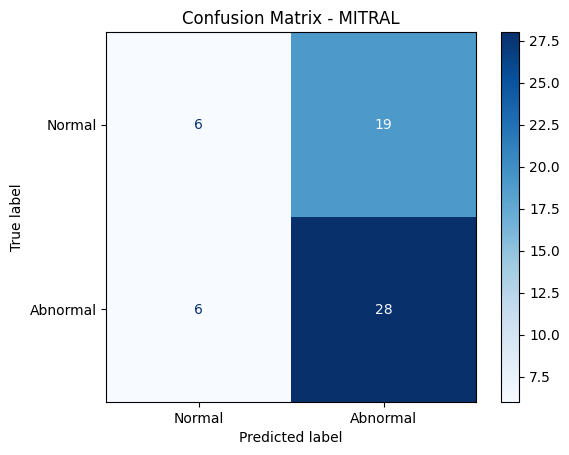

📊 Valve: AORTIC
              precision    recall  f1-score   support

      Normal       0.67      0.32      0.43        25
    Abnormal       0.65      0.89      0.75        35

    accuracy                           0.65        60
   macro avg       0.66      0.60      0.59        60
weighted avg       0.65      0.65      0.62        60



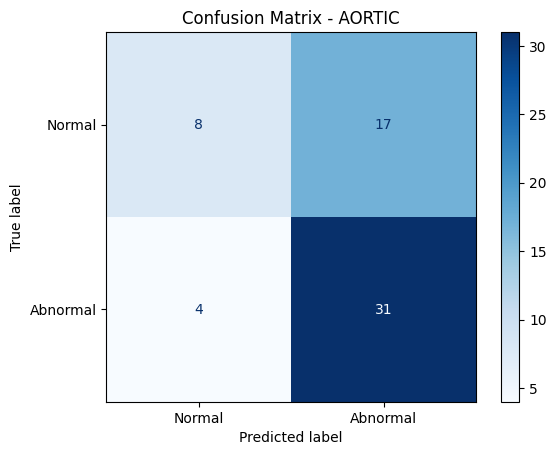

📊 Valve: TRICUSPID
              precision    recall  f1-score   support

      Normal       1.00      0.88      0.94        25
    Abnormal       0.70      1.00      0.82         7

    accuracy                           0.91        32
   macro avg       0.85      0.94      0.88        32
weighted avg       0.93      0.91      0.91        32



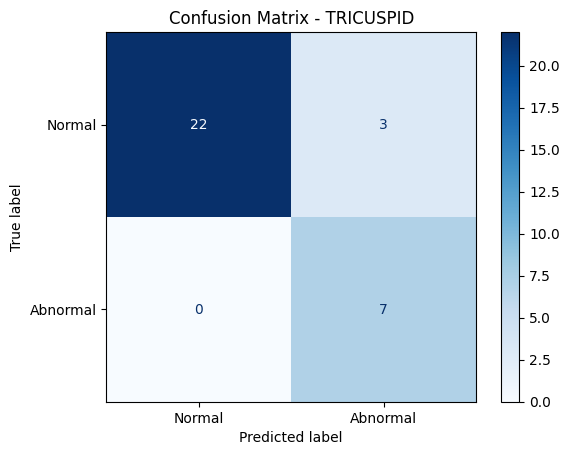

📊 Valve: PULMONARY
              precision    recall  f1-score   support

      Normal       1.00      0.88      0.94        25
    Abnormal       0.62      1.00      0.77         5

    accuracy                           0.90        30
   macro avg       0.81      0.94      0.85        30
weighted avg       0.94      0.90      0.91        30



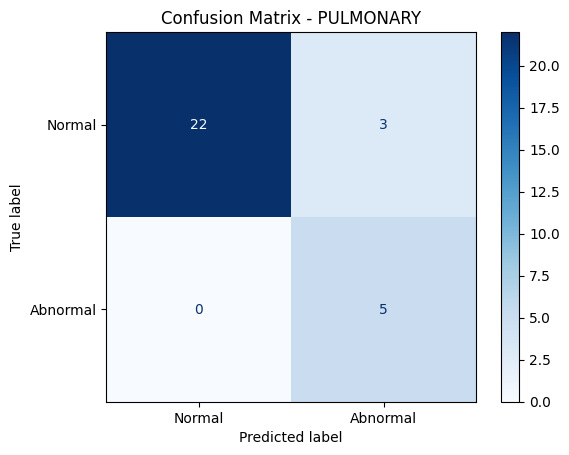

In [20]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

for valve, data in results.items():
    y_true = data["y_true"]
    y_pred = data["y_pred"]

    print(f"📊 Valve: {valve.upper()}")
    print(classification_report(y_true, y_pred, target_names=["Normal", "Abnormal"], zero_division=0))

    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Normal", "Abnormal"])
    disp.plot(cmap="Blues")
    plt.title(f"Confusion Matrix - {valve.upper()}")
    plt.show()


In [23]:
from sklearn.metrics import accuracy_score

# ===== Accuracy ราย valve =====
for valve, data in results.items():
    acc = accuracy_score(data["y_true"], data["y_pred"])
    print(f"✅ {valve.capitalize()} Accuracy: {acc:.4f}")

# ===== Accuracy รวม =====
all_true = []
all_pred = []

for data in results.values():
    all_true.extend(data["y_true"])
    all_pred.extend(data["y_pred"])

overall_acc = accuracy_score(all_true, all_pred)
print(f"\n🌐 Overall Accuracy (All Valves Combined): {overall_acc:.4f}")


✅ Mitral Accuracy: 0.5763
✅ Aortic Accuracy: 0.6500
✅ Tricuspid Accuracy: 0.9062
✅ Pulmonary Accuracy: 0.9000

🌐 Overall Accuracy (All Valves Combined): 0.7127


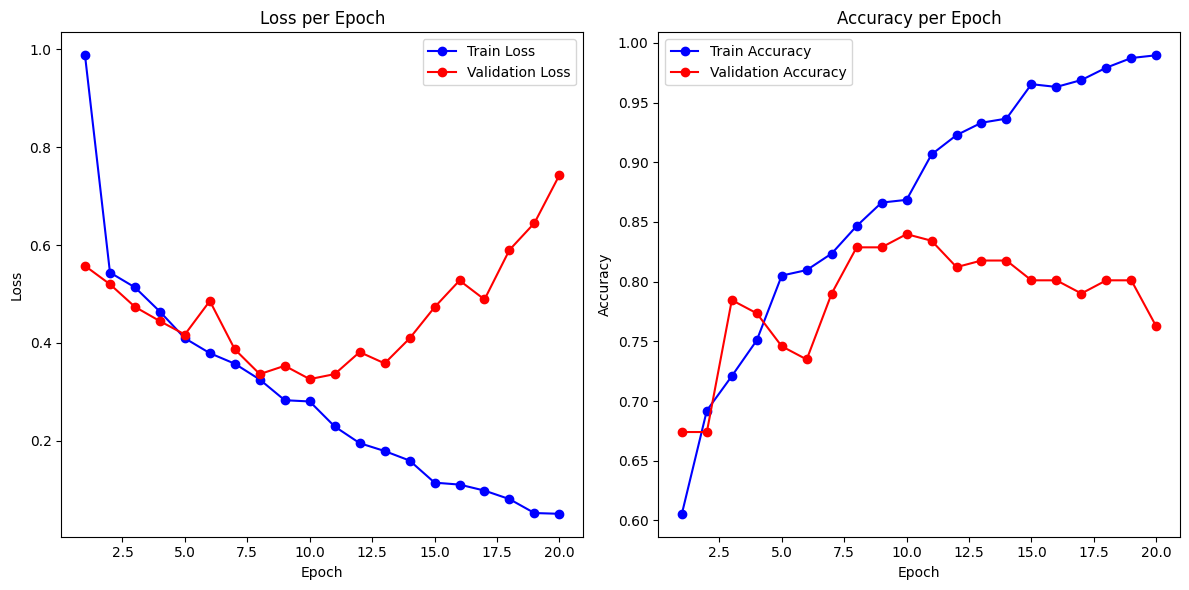

In [24]:
epochs = list(range(1, EPOCHS + 1))

plt.figure(figsize=(12, 6))

# 🔹 Loss Plot
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, marker='o', label='Train Loss', color='blue')
plt.plot(epochs, val_losses, marker='o', label='Validation Loss', color='red')
plt.title("Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

# 🔹 Accuracy Plot
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, marker='o', label='Train Accuracy', color='blue')
plt.plot(epochs, val_accuracies, marker='o', label='Validation Accuracy', color='red')
plt.title("Accuracy per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()
